In [1]:
!pip install dmba

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('DataFiles'):
   # for filename in filenames:
      #  if 'FlightDelays' in filename:
          #  print(os.path.join(dirname, filename))
            #break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ML1: Group 09
# Assignment 3: Flight Delays Dataset

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from dmba import classificationSummary
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [6]:
# load datasest from csv
flight_delays_df = pd.read_csv('FlightDelays.csv')
# preview dataframe
print(flight_delays_df.shape) # dimensions 
flight_delays_df.head() # preview data

(2201, 13)


,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


## Pre-processing

### Clean and Tranform Data

In [7]:
# check missing values, drop if needed
flight_delays_df.isnull().sum()

CRS_DEP_TIME     0
CARRIER          0
DEP_TIME         0
DEST             0
DISTANCE         0
FL_DATE          0
FL_NUM           0
ORIGIN           0
Weather          0
DAY_WEEK         0
DAY_OF_MONTH     0
TAIL_NUM         0
Flight Status    0
dtype: int64

In [8]:
# Check duplicates, remove if needed
flight_delays_df.duplicated().sum()

0

In [9]:
# Make column names consistent
# Make all upper case and replace separated by underscore
flight_delays_df.columns = [col_names.replace(' ','_').upper() for col_names in flight_delays_df.columns]
flight_delays_df.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'WEATHER', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'FLIGHT_STATUS'],
      dtype='object')

In [10]:
# check data structure - columns, data types
flight_delays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRS_DEP_TIME   2201 non-null   int64 
 1   CARRIER        2201 non-null   object
 2   DEP_TIME       2201 non-null   int64 
 3   DEST           2201 non-null   object
 4   DISTANCE       2201 non-null   int64 
 5   FL_DATE        2201 non-null   object
 6   FL_NUM         2201 non-null   int64 
 7   ORIGIN         2201 non-null   object
 8   WEATHER        2201 non-null   int64 
 9   DAY_WEEK       2201 non-null   int64 
 10  DAY_OF_MONTH   2201 non-null   int64 
 11  TAIL_NUM       2201 non-null   object
 12  FLIGHT_STATUS  2201 non-null   object
dtypes: int64(7), object(6)
memory usage: 223.7+ KB


In [11]:
#format FL_DATE column to datetime
flight_delays_df.FL_DATE = pd.to_datetime(flight_delays_df.FL_DATE)
flight_delays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CRS_DEP_TIME   2201 non-null   int64         
 1   CARRIER        2201 non-null   object        
 2   DEP_TIME       2201 non-null   int64         
 3   DEST           2201 non-null   object        
 4   DISTANCE       2201 non-null   int64         
 5   FL_DATE        2201 non-null   datetime64[ns]
 6   FL_NUM         2201 non-null   int64         
 7   ORIGIN         2201 non-null   object        
 8   WEATHER        2201 non-null   int64         
 9   DAY_WEEK       2201 non-null   int64         
 10  DAY_OF_MONTH   2201 non-null   int64         
 11  TAIL_NUM       2201 non-null   object        
 12  FLIGHT_STATUS  2201 non-null   object        
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 223.7+ KB


In [12]:
# check FLIGHT_STATUS values
flight_delays_df.FLIGHT_STATUS.unique()

array(['ontime', 'delayed'], dtype=object)

In [13]:
# create new column FLIGHT_STATUS_NUM
# delayed = 1, ontime = 0
flight_delays_df['FLIGHT_STATUS_NUM'] = (flight_delays_df['FLIGHT_STATUS'] == 'delayed').astype(int)
# print new column values, and new columns list
print(flight_delays_df.FLIGHT_STATUS_NUM.unique())
flight_delays_df.columns

[0 1]


Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'WEATHER', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'FLIGHT_STATUS', 'FLIGHT_STATUS_NUM'],
      dtype='object')

In [14]:
# create new column, with calculated delay time
flight_delays_df['DELAY_DURATION'] = flight_delays_df.CRS_DEP_TIME - flight_delays_df.DEP_TIME
flight_delays_df[['CRS_DEP_TIME','DEP_TIME','DELAY_DURATION']].head(12)

,CRS_DEP_TIME,DEP_TIME,DELAY_DURATION
0,1455,1455,0
1,1640,1640,0
2,1245,1245,0
3,1715,1709,6
4,1039,1035,4
5,840,839,1
6,1240,1243,-3
7,1645,1644,1
8,1715,1710,5
9,2120,2129,-9


In [15]:
# calculate times in hour
flight_delays_df['DEP_TIME_HOUR'] = flight_delays_df.DEP_TIME // 100
flight_delays_df['CRS_DEP_TIME_HOUR'] = flight_delays_df.CRS_DEP_TIME // 100
flight_delays_df[['DEP_TIME','DEP_TIME_HOUR','CRS_DEP_TIME','CRS_DEP_TIME_HOUR']].head(12)

,DEP_TIME,DEP_TIME_HOUR,CRS_DEP_TIME,CRS_DEP_TIME_HOUR
0,1455,14,1455,14
1,1640,16,1640,16
2,1245,12,1245,12
3,1709,17,1715,17
4,1035,10,1039,10
5,839,8,840,8
6,1243,12,1240,12
7,1644,16,1645,16
8,1710,17,1715,17
9,2129,21,2120,21


### Summary Statistics

In [16]:
# summary statistics
flight_delays_df.describe()

,CRS_DEP_TIME,DEP_TIME,DISTANCE,FL_NUM,WEATHER,DAY_WEEK,DAY_OF_MONTH,FLIGHT_STATUS_NUM,DELAY_DURATION,DEP_TIME_HOUR,CRS_DEP_TIME_HOUR
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,1371.938664,1369.298955,211.871422,3815.086324,0.014539,3.905498,16.024989,0.194457,2.639709,13.318037,13.516129
std,432.697149,442.462754,13.316815,2409.750224,0.119725,1.903149,8.677390,0.395872,80.028129,4.460910,4.349696
min,600.000000,10.000000,169.000000,746.000000,0.000000,1.000000,1.000000,0.000000,-425.000000,0.000000,6.000000
25%,1000.000000,1004.000000,213.000000,2156.000000,0.000000,2.000000,8.000000,0.000000,-2.000000,10.000000,10.000000
50%,1455.000000,1450.000000,214.000000,2385.000000,0.000000,4.000000,16.000000,0.000000,3.000000,14.000000,14.000000
75%,1710.000000,1709.000000,214.000000,6155.000000,0.000000,5.000000,23.000000,0.000000,42.000000,17.000000,17.000000
max,2130.000000,2330.000000,229.000000,7924.000000,1.000000,7.000000,31.000000,1.000000,2110.000000,23.000000,21.000000


### Variance and Correlation

In [17]:
# Variabilities
print(flight_delays_df.var(numeric_only = True))

CRS_DEP_TIME         1.872268e+05
DEP_TIME             1.957733e+05
DISTANCE             1.773376e+02
FL_NUM               5.806896e+06
WEATHER              1.433398e-02
DAY_WEEK             3.621974e+00
DAY_OF_MONTH         7.529710e+01
FLIGHT_STATUS_NUM    1.567147e-01
DELAY_DURATION       6.404501e+03
DEP_TIME_HOUR        1.989972e+01
CRS_DEP_TIME_HOUR    1.891985e+01
dtype: float64


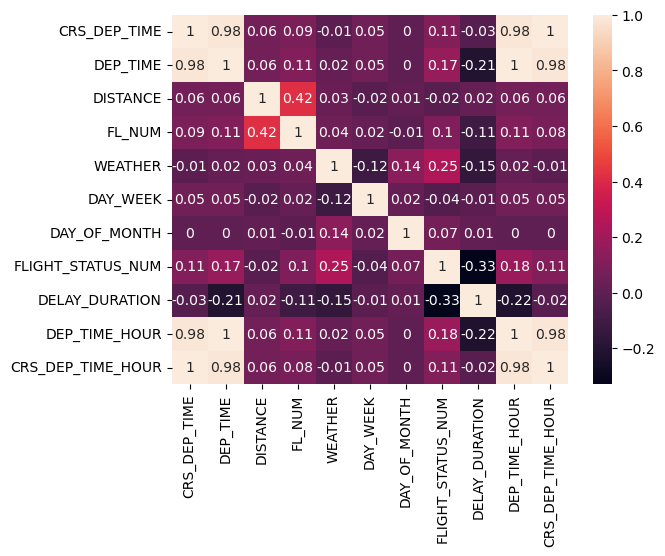

In [18]:
# Correlation
corr = flight_delays_df.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

CRSE_DEP_TIME, DEP_TIME, FL_NUM/CARRIER, WEATHER
, DAY, DAY_WEEK

CRSE_DEP_TIME, FL_NUM, WEATHER, DAY_OF_MONTH, DAY_WEEK

### Visualize

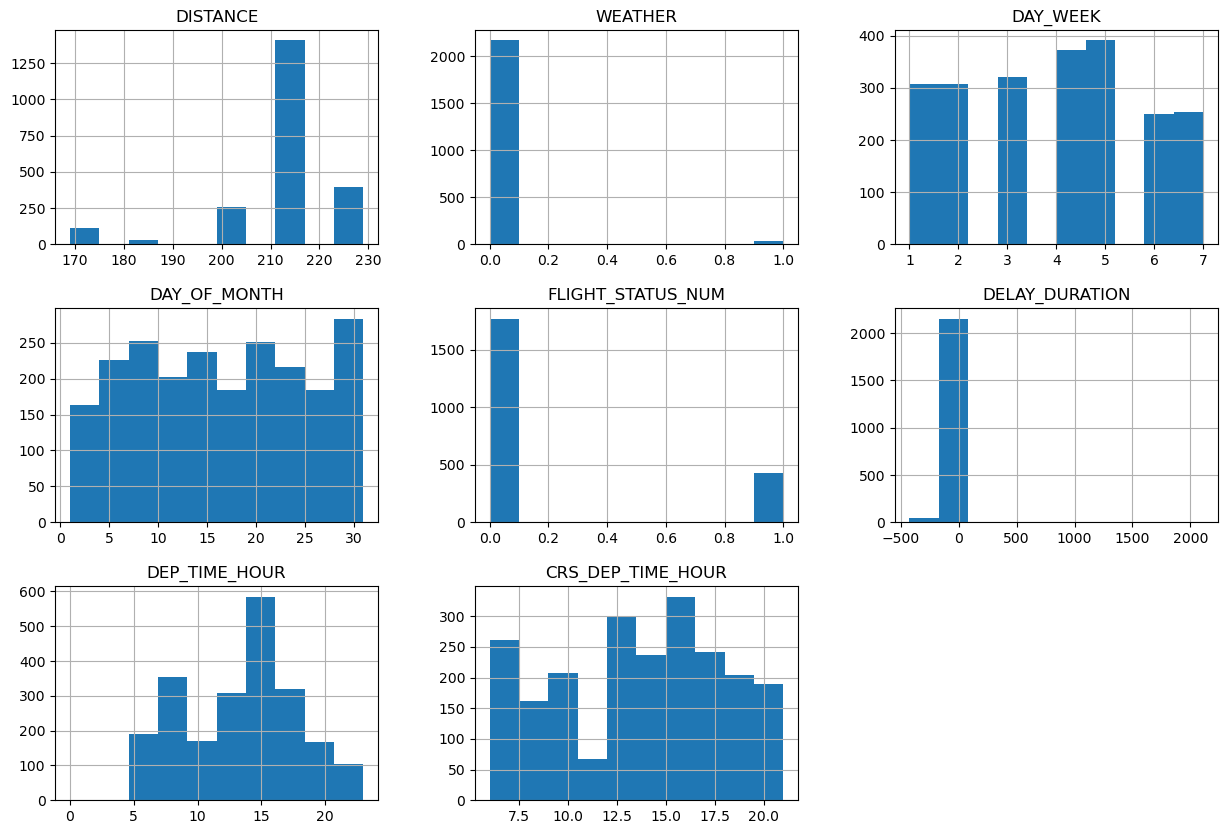

In [19]:
# Histograms
flight_delays_df[['DISTANCE','WEATHER', 'DAY_WEEK', 'DAY_OF_MONTH'
                 , 'FLIGHT_STATUS_NUM', 'DELAY_DURATION'
                 , 'DEP_TIME_HOUR','CRS_DEP_TIME_HOUR']].hist(bins=10, figsize=(15,10))
plt.show()

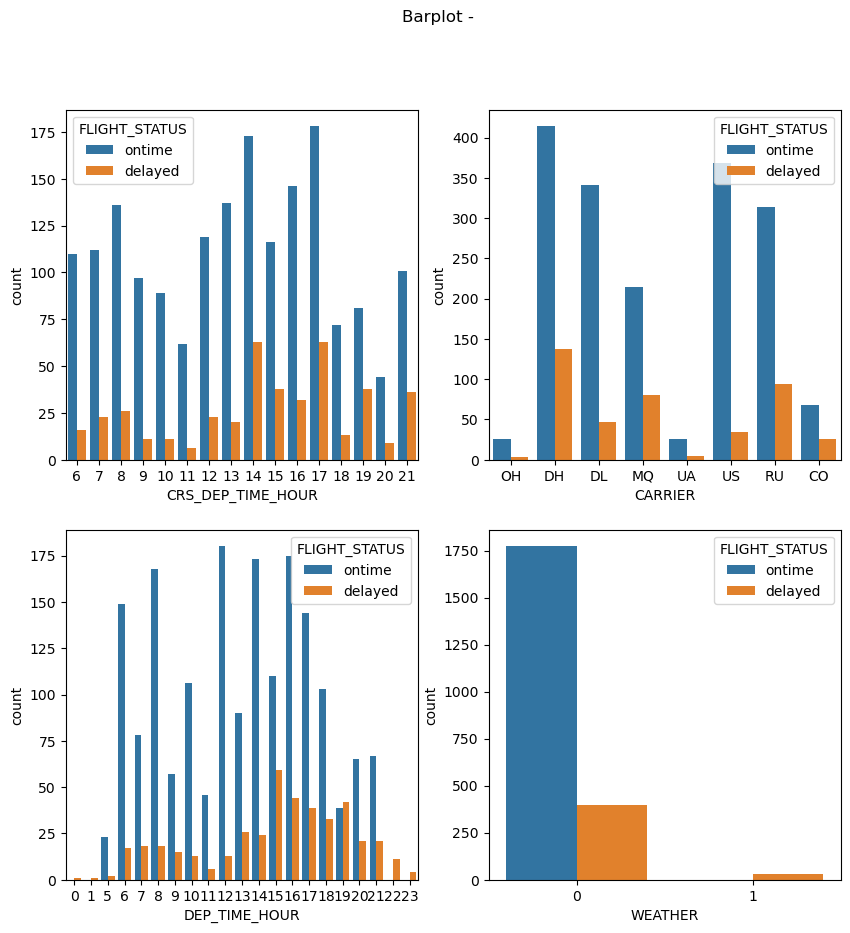

In [20]:
# Barplot - variables with significant correlation to FLIGHT_STATUS
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Barplot - ")

g1 = sns.countplot(ax=axes[0,0], data=flight_delays_df, x=flight_delays_df.CRS_DEP_TIME_HOUR, hue='FLIGHT_STATUS')
#g1.bar_label(g1.containers[0])
g2 = sns.countplot(ax=axes[1,0], data=flight_delays_df, x=flight_delays_df.DEP_TIME_HOUR, hue='FLIGHT_STATUS')
#g2.bar_label(g2.containers[0])
g3 =sns.countplot(ax=axes[0,1], data=flight_delays_df, x=flight_delays_df.CARRIER, hue='FLIGHT_STATUS')
#g3.bar_label(g3.containers[0])
g4 =sns.countplot(ax=axes[1,1], data=flight_delays_df, x=flight_delays_df.WEATHER, hue='FLIGHT_STATUS')
#g3.bar_label(g3.containers[0])

plt.show()

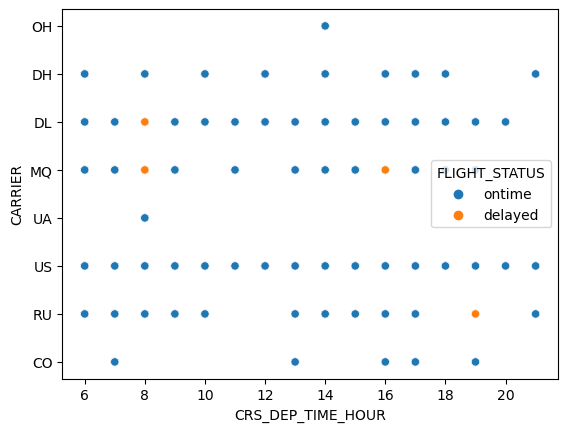

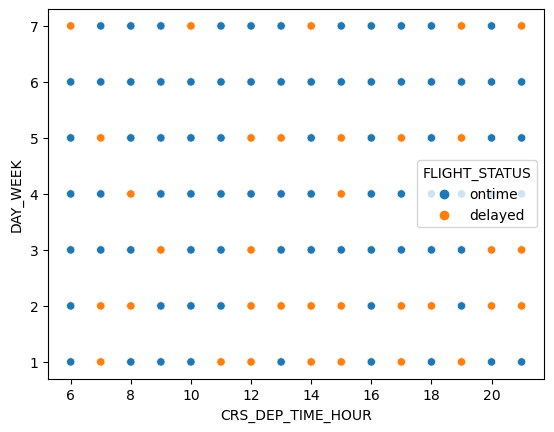

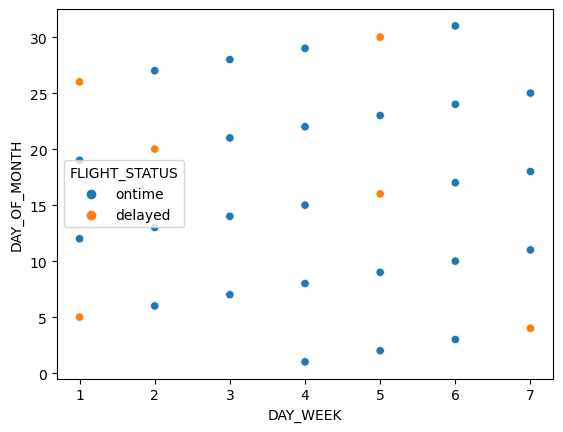

In [21]:
# scatterplot of variable with significant correlation
sns.scatterplot(x='CRS_DEP_TIME_HOUR', y = 'CARRIER', hue='FLIGHT_STATUS', data=flight_delays_df)
plt.show()
# scatterplot of variable with significant correlation
sns.scatterplot(x='CRS_DEP_TIME_HOUR', y = 'DAY_WEEK', hue='FLIGHT_STATUS', data=flight_delays_df)
plt.show()
# scatterplot of variable with significant correlation
sns.scatterplot(x='DAY_WEEK', y = 'DAY_OF_MONTH', hue='FLIGHT_STATUS', data=flight_delays_df)
plt.show()

## Modeling

In [22]:
# for predictors, we used the variables with higher correlations to FLIGHT_STATUS
# then added some categorical variables
predictors = ['CRS_DEP_TIME'
              ,'WEATHER'
              , 'CARRIER','ORIGIN','DEST'
             ]
target = 'FLIGHT_STATUS'

target_values = list(flight_delays_df.FLIGHT_STATUS.unique())

X = pd.get_dummies(flight_delays_df[predictors])
y = flight_delays_df[target]

X_train, X_valid , y_train , y_valid = train_test_split (X, y, test_size =0.3, random_state =1)

### K-Nearest Neighbors (k-NN)

In [23]:
# tried 3, 5, 7, 9, 11 k values
delays_knn = KNeighborsClassifier(n_neighbors=5)
delays_knn.fit(X_train , y_train)
# train score
delays_knn_train_pred = delays_knn.predict(X_train)
classificationSummary(y_train, delays_knn_train_pred)
# validate score
delays_knn_valid_pred = delays_knn.predict(X_valid)
classificationSummary(y_valid, delays_knn_valid_pred)

Confusion Matrix (Accuracy 0.7942)

       Prediction
Actual    0    1
     0   65  239
     1   78 1158
Confusion Matrix (Accuracy 0.7927)

       Prediction
Actual   0   1
     0  30  94
     1  43 494


C:\Users\rahul\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rahul\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

### Naive Bayes

In [114]:
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train , y_train)

# train score
delays_nb_train_pred = delays_nb.predict(X_train)
classificationSummary(y_train, delays_nb_train_pred)
#validate score
delays_nb_valid_pred = delays_nb.predict(X_valid)
classificationSummary(y_valid, delays_nb_valid_pred)

Confusion Matrix (Accuracy 0.8156)

       Prediction
Actual    0    1
     0   20  284
     1    0 1236
Confusion Matrix (Accuracy 0.8306)

       Prediction
Actual   0   1
     0  12 112
     1   0 537


### Support Vector Machine (SVM)

In [115]:
# SVM model
delays_svm = SVC()
delays_svm.fit(X_train, y_train)
# train score
delays_svm_train_pred = delays_svm.predict(X_train)
classificationSummary(y_train, delays_svm_train_pred)
#validate score
delays_svm_valid_pred = delays_svm.predict(X_valid)
classificationSummary(y_valid, delays_svm_valid_pred)

Confusion Matrix (Accuracy 0.8026)

       Prediction
Actual    0    1
     0    0  304
     1    0 1236
Confusion Matrix (Accuracy 0.8124)

       Prediction
Actual   0   1
     0   0 124
     1   0 537
